<a href="https://colab.research.google.com/github/yexf308/MAT592/blob/main/18_GMM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline 
from IPython.display import Image
import numpy.linalg as LA

Populating the interactive namespace from numpy and matplotlib


#Gaussian Mixture Models: Implementation


Rewrite log-likelihood for Gaussian mixture:

\begin{align}
\log \ell(\theta) = \sum_{i=1}^N\log p(\mathbf{x}^{(i)}|\theta)=\sum_{i=1}^N\log\sum_{z^{(i)}=1}^K p(\mathbf{x}^{(i)}, z^{(i)}|\theta) 
\end{align}

where $\mathbf{x}$ are observed dataset and $z$ are the cluster membership which are hidden variables. Unfortunately, it is very hard to optimize. 

## Expectation-Maximization(EM) algorithm

### Background
The basic idea behind EM algorithm is alternate between estimating the hidden variables during the **E step** (expectation step), and then using the fully observed data to compute the MLE during the **M step** (maximization step). Of course we need to iterate this process since the expected values depend on the parameters, but the parameters depend on the expected values. 


- Consider a set of arbitary distribution $q(z^{(i)})$ over each hidden variable $z^{(i)}$. The observed data log likelihood can written as follows: 
$$ \log \ell(\theta)=\sum_{i=1}^N\log\left(\sum_{c=1}^K q(z^{(i)}=c) \frac{p(\mathbf{x}^{(i)}, z^{(i)}=c|\theta)}{q(z^{(i)}=c)}\right) $$

- Using Jensen's inequality, $\phi(\sum_i a_ix_i)\ge  \sum_i a_i \phi(x_i)$ for any concave function $\phi$ and $\sum_i a_i=1$.
\begin{align}
\log \ell(\theta)&\ge \sum_{i=1}^N \sum_{c=1}^K q(z^{(i)}=c) \log\left( \frac{p(\mathbf{x}^{(i)}, z^{(i)}=c|\theta)}{q(z^{(i)}=c)}\right) \\
&\triangleq \sum_{i=1}^N \mathcal{E}[\theta,z^{(i)}|\mathbf{x}^{(i)}] = \mathcal{E}[\theta, \{z^{(i)}\}_{i=1}^N |\{\mathbf{x}^{(i)}\}_{i=1}^N ] 
\end{align}
 $\mathcal{E}[\theta, \{z^{(i)}\}_{i=1}^N |\{\mathbf{x}^{(i)}\}_{i=1}^N ]$ is called the **evidence lower bound**, since it is a lower bound on the log marginal likelihood $\log p(\{\mathbf{x}^{(i)}\}_{i=1}^N|\theta)$ 



We see that the lower bound is a sum of $N$ terms, each of which has the following form
\begin{align}
\mathcal{E}[\theta,z^{(i)}|\mathbf{x}^{(i)}] &= \sum_{c=1}^K q(z^{(i)}=c) \log\left( \frac{p(\mathbf{x}^{(i)}, z^{(i)}=c|\theta)}{q(z^{(i)}=c)}\right) \\
&=\sum_{c=1}^K q(z^{(i)}=c) \log\left( \frac{p(z^{(i)}=c| \mathbf{x}^{(i)},\theta)p(\mathbf{x}^{(i)}|\theta)}{q(z^{(i)}=c)}\right)\\
&= \sum_{c=1}^K q(z^{(i)}=c) \log\left( \frac{p(z^{(i)}=c| \mathbf{x}^{(i)},\theta)}{q(z^{(i)}=c)}\right) + \sum_{c=1}^K q(z^{(i)}=c)  \log p(\mathbf{x}^{(i)}|\theta) \\
&=-\text{KL}(q(z^{(i)})||p(z^{(i)}| \mathbf{x}^{(i)},\theta)) + \log p(\mathbf{x}^{(i)}|\theta) 
\end{align}
where $\text{KL}(q||p)=\sum_z q(z)\log(\frac{q(z)}{p(z)})$ is the Kullback-Leibler divergence (or KL divergence for short)
between probability distributions $q$ and $p$. 

- The key
property we need here is that $\text{KL}(q||p)\ge 0 $ and $\text{KL}(q||p)=0$ iff $q=p$. 

- we can maximize the
lower bound $\mathcal{E}[\theta, \{z^{(i)}\}_{i=1}^N |\{\mathbf{x}^{(i)}\}_{i=1}^N ]$ with respect to $\{z^{(i)}\}$ by setting each one to $q^*(z^{(i)})=p(z^{(i)}| \mathbf{x}^{(i)},\theta)$. 

 This ensures the ELBO is a **tight lower bound**
$$ \mathcal{E}[\theta, \{z^{(i)}\}_{i=1}^N |\{\mathbf{x}^{(i)}\}_{i=1}^N ]=\sum_{i=1}^N\log p(\mathbf{x}^{(i)}|\theta)=\log \ell(\theta)$$





### Construct the EM algorithm
At each the $t$-iteration with $\theta^t$, EM algorithm constructs an **auxiliary function**,
$$ q(\color{blue}{\theta}; \color{red}{\theta^t}) = \sum_{i=1}^N \sum_{c=1}^K \underbrace{p(z^{(i)}=c|\mathbf{x}^{(i)},\color{red}{\theta^t})}_{q(z^{(i)})}\log \frac{p(\mathbf{x}^{(i)},z^{(i)}=c|\color{blue}{\theta})}{p(z^{(i)}=c|\mathbf{x}^{(i)},\color{red}{\theta^t})}$$ 
which is a lower envelope of $\log \ell(\theta)$, i.e, 
$$\log \ell(\theta) \ge q(\color{blue}{\theta}; \color{red}{\theta^t}), \forall \theta $$
with the equality holds at $\theta^t=\theta$.

- The EM algorithm iterates for $t=0,1,\dots$ to update $\theta$:
$$\color{red}{\theta_{t+1}} = \arg\max_{\theta}q(\color{blue}{\theta}; \color{red}{\theta^t}) $$

- EM algorithm is ascent for maximization:
$$ \log \ell(\theta^{t+1})\ge q(\theta^{t+1}; \theta^t)\ge q(\theta^{t};\theta^t)=\log \ell(\theta^t)$$

- In general, global maximum is not guaranteed because the problem is
non-convex


In [ ]:
display(Image(url='https://github.com/yexf308/MAT592/blob/main/image/EM.png?raw=true', width=600))

## EM algorithm in GMM
### E(xpecation) step
Evaluate the probability $p(z^{(i)}| \mathbf{x}^{(i)},\theta^t)$ using the current parameters $\theta^t =\{\pi_c^t, \mu_c^t, \Sigma_c^t\}_{c=1}^K$:

 \begin{align}
 \phi_c^{(i), t}\triangleq p(z^{(i)}=c| \mathbf{x}^{(i)},\color{red}{\theta^t}) &= \frac{p( \mathbf{x}^{(i)}|z^{(i)}=c, \theta^t)p(z^{(i)}=c| \color{red}{\theta^t})}{p(\mathbf{x}^{(i)}|\color{red}{\theta^t})}  \qquad \text{By Bayes rule} \\
&= \frac{\pi_c^t p(\mathbf{x}^{(i)} | \mu_c^t, \Sigma_c^t)}{\sum_{j=1}^K \pi_j^t p(\mathbf{x}^{(i)} | \mu_j^t, \Sigma_j^t) }, \qquad \forall 1\le i\le N, 1\le c\le K.
 \end{align}
 Where 
 $$ p(\mathbf{x}^{(i)} | \mu_c^t, \Sigma_c^t) = \frac{1}{\sqrt{(2\pi)^d|\Sigma_c|}}\exp\left(-\frac{1}{2}(\mathbf{x}^{(i)}-\mu_c)^\top \Sigma_c^{-1}(\mathbf{x}^{(i)}-\mu_c)\right), \qquad 1\le c\le K$$
 is the PDF for the $c$-th Gaussian distribution of the mixture. 

 **E step gives the clustering:**

 - $\phi_c^{(i)}= p(z^{(i)}=c| \mathbf{x}^{(i)},\theta)$ is the posterior probability: the probability that observation $\mathbf{x}^{(i)}$ comes from the cluster $c$, given the model parameter $\theta$. 

 - $(\phi_1^{(i)}, \phi_2^{(i)}, \dots, \phi_K^{(i)})$ is the probability prediction for $\mathbf{x}^{(i)}$ belonging to each cluster. 

 - Having learned model parameters of Gaussian mixture, we cluster $\mathbf{x}^{(i)}$ by checking the highest posterior probability 
$$ z^{(i)} = \text{arg}\max_{1\le c\le K} \phi_c^{(i)}.$$
This is similar to the prediction step of logistic regression.

### M(aximization) step 

Update parameters by solving

$$\color{red}{\theta^{t+1}}=\arg\max_{\theta} q(\color{blue}\theta, \color{red}{\theta^{t}}) = \arg\max_{\theta}\sum_{i=1}^N \sum_{c=1}^K \phi_{c}^{(i),t} \log \frac{p(\mathbf{x}^{(i)}, z^{(i)}=c|\color{blue}{\theta})}{\phi_{c}^{(i),t} }$$

using the computed posterior probabilities $\phi_{c}^{(i),t}$ from E step. 

We can switch the order of sum and find out we only need to maximize for each individual $c$.

Equvilently, 
\begin{align}
\pi_c^{t+1}, \mu_c^{t+1}, \Sigma_c^{t+1} &= \arg\max_{\pi_c, \mu_c, \Sigma_c}\sum_{i=1}^N \phi_{c}^{(i),t} \log p(\mathbf{x}^{(i)}, z^{(i)}=c|\{\pi_c, \mu_c, \Sigma_c\})\\
&= \arg\max_{\pi_c, \mu_c, \Sigma_c} \sum_{i=1}^N  \phi_{c}^{(i),t} \log\left[ \pi_c p(\mathbf{x}^{(i)} |\mu_c, \Sigma_c)\right] \\
& = \arg\max_{ \mu_c, \Sigma_c} \sum_{i=1}^N \phi_{c}^{(i),t} \log p(\mathbf{x}^{(i)} |\mu_c, \Sigma_c) + \arg\max_{ \pi_c} \sum_{i=1}^N \phi_{c}^{(i),t} \log \pi_c
\end{align}

note that we have constraints $\pi_c\ge 0$ and $\sum_{c=1}^K \pi_c =1$.

This optimization has analytical solution! Do it yourself.

\begin{align}
& \pi_c^{t+1}=\frac{\sum_{i=1}^N \phi_{c}^{(i),t}}{\sum_{c=1}^K\sum_{i=1}^N \phi_{c}^{(i),t}}=\frac{1}{N}\sum_{i=1}^N \phi_{c}^{(i),t}, \\
& \mu_c^{t+1} = \frac{\sum_{i=1}^N \phi_{c}^{(i),t}  \mathbf{x}^{(i)}}{\sum_{i=1}^N \phi_{c}^{(i),t}} , \\
& \Sigma_c^{t+1} = \frac{\sum_{i=1}^N \phi_{c}^{(i),t}  \left[\mathbf{x}^{(i)}-\mu_c^{t+1}\right]\left[\mathbf{x}^{(i)}-\mu_c^{t+1}\right]^T}{\sum_{i=1}^N \phi_{c}^{(i),t}}.
\end{align}




## K-means is a special case of EM

K-means is essentially a special case of Gaussian mixture model, assuming the
data is generated as follows:

- We fix $\Sigma_c= \sigma\mathbb{I}_d$ and $\pi_c=1/K$ for all the clusters (so we just have to estimate the means $\mu_c$). 

- We approximate the E step, by replacing the posterior probability with hard cluster assignments, i.e, $z^{(i)} = \text{arg}\max_{1\le c\le K} \phi_c^{(i)}$ and set $\phi_c^{(i)} =\mathbb{1}_{z^{(i)} = c}$

With this approximation, the analytical solution in M step reduces to K-means equation. Therefore, K-means favors rounded clusters of equal size.

# Let's code this!

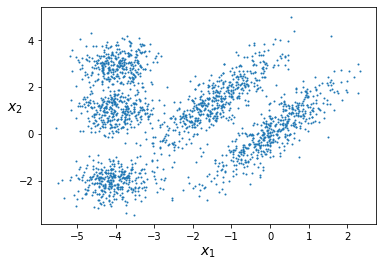

In [2]:
from sklearn.datasets import make_blobs

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

if 0:
    blob_centers = np.array(
        [[ 0.2,  2.3],
         [-1.5 ,  2.3],
         [-2.8,  1.8],
         [-2.8,  2.8],
         [-2.8,  1.3]])
    blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
    X, y = make_blobs(n_samples=2000, centers=blob_centers,
                      cluster_std=blob_std, random_state=7)

if 1:
    # two off-diagonal blobs
    X1, _ = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
    X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
    # three spherical blobs
    blob_centers = np.array(
        [[ -4,  1],
         [-4 ,  3],
         [-4,  -2]])
    s = 0.5
    blob_std = np.array([s, s, s])
    X2, _ = make_blobs(n_samples=1000, centers=blob_centers,
                      cluster_std=blob_std, random_state=7)
    
    X = np.r_[X1, X2]
    K = 5
    
figure()
plot_clusters(X)

In [15]:
from scipy.stats import multivariate_normal 

def euclidean_distance(x1, x2):
    return sqrt(sum((x1 - x2) ** 2))

def initialize(X, K):
    # N has the number of rows while d has the number of columns of dataset X 
    N, d = X.shape 

    # initial weights given to each cluster are stored in phi or P(Ci=j)
    Pi = full(shape=K, fill_value=1/K) 

    # initial weights given to each data point wrt to each cluster or P(Xi|Zi=j)
    weights = full(shape=(N,d), fill_value=1/K)
        
    # randomly sample K points 
    random_row = random.randint(low=0, high=N, size=K)

    # initial value of mean of K Gaussians 
    Mu = [  X[row_index,:] for row_index in random_row ] 

    # initial value of covariance matrix of K Gaussians
    Sigma = [ cov(X.T) for _ in range(K) ] 
    # theta =(Mu,Sigma,Pi)
    return Pi, Mu, Sigma, weights

# computer posterior probability of each data point wrt each cluster
# parameters are Pi, Mu, Sigma
def predict_posterior(X, K, Pi, Mu, Sigma):
    N = X.shape[0]
    # Creates a N*K matrix denoting probability of each point wrt each cluster 
    likelihood = zeros( (N, K) ) 
    for i in range(K):
        distribution = multivariate_normal(mean=Mu[i],cov=Sigma[i])
            # pdf : probability denisty function
        likelihood[:,i] = distribution.pdf(X) 

    numerator = likelihood * Pi
    denominator = numerator.sum(axis=1)[:, np.newaxis]
    weights = numerator / denominator
    return weights


# E-Step: update weights holding Pi Mu Sigma constant
def e_step(X, K, Pi, Mu, Sigma):
    # updated weights(i,j)=P(Xi|Zi=j)
    weights   = predict_posterior(X, K, Pi, Mu, Sigma)
    return weights


# M-Step: update Mu, Sigma, Pi, holding weights constant
def m_step(X, K, weights):
    # mean of sum of probability of all data points wrt to one cluster is new updated probability of cluster Pi_c
    Pi_update = weights.mean(axis=0)  
    Mu_update = [[] for _ in range(K)]
    Sigma_update = [[] for _ in range(K)]
    for i in range(K):
        weight_i = weights[:, [i]]
        total_weight = weight_i.sum()
        Mu_update[i]    = (X * weight_i).sum(axis=0) / total_weight
        Sigma_update[i] = cov(X.T, aweights=(weight_i/total_weight).flatten(), bias=True)  

    return Pi_update, Mu_update, Sigma_update    
    
# predict function 
def predict(X, K, Pi, Mu, Sigma):
   weights = predict_posterior(X, K, Pi, Mu, Sigma)
   # datapoint belongs to cluster with maximum probability
   # returns this value
   return argmax(weights, axis=1)


def plot_clusters(X, z=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.scatter(X[:, 0], X[:, 1], c=z, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    plt.grid()
    plt.tight_layout()   
    plt.show()

In [16]:
def GMM_fit(X, K, max_iter=100):
  # initialise parameters like weights, Pi, Mu, Sigma of all Gaussians in dataset X
  Pi, Mu, Sigma, weights = initialize(X,K)
  for j in range(max_iter):
    z = predict(X, K, Pi, Mu, Sigma)
    plot_clusters(X, z)
    # iterate to update the value of P(Xi/zi=j)
    weights = e_step(X, K, Pi, Mu, Sigma)
    Pi_old  = Pi;
    Mu_old  = Mu;
    # iterate to update the value of Mu, Sigma and Pi as the clusters shift
    Pi, Mu, Sigma  = m_step(X, K, weights)

    distances = [ norm(Mu[i] - Mu_old[i]) for i in range(K)] 
    if sum(distances) == 0:
      print('Number of iteration is ', j+1)
      break

  z = predict(X, K, Pi, Mu, Sigma)
  plot_clusters(X, z)
  return z    



In [ ]:
z=GMM_fit(X, 5)